# Aprendizagem por Reforço

Vamos descrever o "problema do táxi". Queremos construir um táxi autônomo que possa pegar passageiros em um conjunto de locais fixos, deixá-los em outro local e chegar lá no menor tempo possível, evitando obstáculos.

O AI Gym nos permite criar este ambiente rapidamente:

In [4]:
import gym  # Importa a biblioteca gym para ambientes de aprendizado por reforço
import random  # Importa a biblioteca random para geração de números aleatórios

# Define a semente para a geração de números aleatórios, garantindo reprodutibilidade
random.seed(1234)

# Cria o ambiente "Taxi-v3"
streets = gym.make("Taxi-v3").env

# Renderiza o ambiente, exibindo a interface gráfica
streets.render()


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [5]:
# Resetando o ambiente para o estado inicial
streets.reset()

# Loop de exemplo para tomar algumas ações aleatórias
for _ in range(1):
    action = streets.action_space.sample()  # Toma uma ação aleatória
    observation, reward, done, info = streets.step(action)  # Executa a ação
    streets.render()  # Renderiza o ambiente
    if done:  # Se o episódio terminou
        break


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)


Vamos detalhar o que estamos vendo aqui:

- R, G, B e Y são locais de coleta ou entrega.
- A letra AZUL indica onde precisamos buscar alguém.
- A letra MAGENTA indica para onde aquele passageiro deseja ir.
- As linhas sólidas representam paredes que o táxi não pode atravessar.
- O retângulo preenchido representa o próprio táxi - é amarelo quando está vazio e verde quando transporta um passageiro.

Nosso mundinho aqui, que chamamos de “ruas”, é uma grade 5x5. O estado deste mundo a qualquer momento pode ser definido por:

- Onde está o táxi (um de 5x5 = 25 locais)
- Qual é o destino atual (4 possibilidades)
- Onde o passageiro está (5 possibilidades: em um dos destinos, ou dentro do táxi)

Portanto, há um total de 25 x 4 x 5 = 500 estados possíveis que descrevem o nosso mundo.

Para cada estado, existem seis ações possíveis:

- Mova-se para o sul, leste, norte ou oeste
- Pegue um passageiro
- Deixar um passageiro

O Q-Learning ocorrerá usando as seguintes recompensas e penalidades em cada estado:

- Uma entrega bem-sucedida rende +20 pontos
- Cada passo dado enquanto dirige um passageiro gera uma penalidade de -1 ponto
- Pegar ou deixar em um local ilegal gera uma penalidade de -10 pontos

Atravessar uma parede simplesmente não é permitido.

Vamos definir um estado inicial, com o táxi no local (2, 3), o passageiro no local de partida 2 e o destino no local 0:

In [6]:
initial_state = streets.encode(2, 3, 2, 0)

streets.s = initial_state

streets.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)


Vamos examinar a tabela de recompensas para este estado inicial:

In [7]:
streets.P[initial_state]

{0: [(1.0, 368, -1, False)],
 1: [(1.0, 168, -1, False)],
 2: [(1.0, 288, -1, False)],
 3: [(1.0, 248, -1, False)],
 4: [(1.0, 268, -10, False)],
 5: [(1.0, 268, -10, False)]}

Veja como interpretar isso - cada linha corresponde a uma ação potencial neste estado: mover-se para Sul, Norte, Leste ou Oeste, embarque ou desembarque. Os quatro valores em cada linha são a probabilidade atribuída a essa ação, o próximo estado resultante dessa ação, a recompensa por essa ação e se essa ação indica que ocorreu uma desistência bem-sucedida. 

Assim, por exemplo, mudar para o norte deste estado nos colocaria no estado número 368, incorreria em uma penalidade de -1 por ocupar tempo e não resultaria em uma desistência bem-sucedida.

Então, vamos fazer Q-learning! Primeiro precisamos treinar nosso modelo. Em alto nível, treinaremos mais de 10.000 corridas simuladas de táxi. Para cada execução, avançaremos no tempo, com 10% de chance em cada etapa de realizar uma etapa exploratória aleatória, em vez de usar os valores Q aprendidos para guiar nossas ações.

In [8]:
import numpy as np  # Importa a biblioteca NumPy para operações numéricas

# Inicializa a Q-table com zeros
q_table = np.zeros([streets.observation_space.n, streets.action_space.n])

# Configurações de aprendizado
learning_rate = 0.1  # Taxa de aprendizado
discount_factor = 0.6  # Fator de desconto
exploration = 0.1  # Probabilidade de explorar ações aleatórias
epochs = 10000  # Número de episódios

# Loop principal de treinamento
for taxi_run in range(epochs):
    state = streets.reset()  # Reinicia o ambiente e obtém o estado inicial
    done = False  # Sinaliza se o episódio terminou
    
    while not done:  # Enquanto o episódio não terminar
        random_value = random.uniform(0, 1)  # Gera um valor aleatório entre 0 e 1
        if (random_value < exploration):
            action = streets.action_space.sample()  # Explora uma ação aleatória
        else:
            action = np.argmax(q_table[state])  # Usa a ação com o maior valor Q
            
        next_state, reward, done, info = streets.step(action)  # Executa a ação e obtém o novo estado
        
        # Atualiza a Q-value usando a fórmula do Q-learning
        prev_q = q_table[state, action]  # Valor Q anterior
        next_max_q = np.max(q_table[next_state])  # Valor Q máximo do próximo estado
        new_q = (1 - learning_rate) * prev_q + learning_rate * (reward + discount_factor * next_max_q)  # Nova Q-value
        q_table[state, action] = new_q  # Atualiza a Q-table
        
        state = next_state  # Move para o próximo estado


Portanto, agora temos uma tabela de valores Q que pode ser usada rapidamente para determinar o próximo passo ideal para qualquer estado! Vamos verificar na tabela nosso estado inicial acima:

In [9]:
q_table[initial_state]

array([-2.40329705, -2.39307027, -2.41335672, -2.3639511 , -7.26648764,
       -7.8998947 ])

O valor q mais baixo aqui corresponde à ação "ir para oeste", o que faz sentido - essa é a rota mais direta em direção ao nosso destino a partir desse ponto. Parece funcionar! Vamos ver isso em ação!

In [7]:
from IPython.display import clear_output  # Importa função para limpar a saída do notebook
from time import sleep  # Importa função para criar pausas no código

# Loop para simular 10 viagens
for tripnum in range(1, 11):
    state = streets.reset()  # Reinicia o ambiente e obtém o estado inicial
    
    done = False  # Sinaliza se a viagem terminou
    trip_length = 0  # Contador para o comprimento da viagem
    
    # Loop para executar os passos da viagem, com limite de 25 passos
    while not done and trip_length < 25:
        action = np.argmax(q_table[state])  # Escolhe a melhor ação com base na Q-table
        next_state, reward, done, info = streets.step(action)  # Executa a ação e obtém o novo estado
        
        clear_output(wait=True)  # Limpa a saída anterior do notebook
        print("Trip number " + str(tripnum) + " Step " + str(trip_length))  # Exibe o número da viagem e o passo atual
        print(streets.render(mode='ansi'))  # Renderiza o estado do ambiente em formato ASCII
        sleep(0.5)  # Pausa de 0,5 segundos para melhor visualização
        state = next_state  # Atualiza o estado atual para o próximo estado
        trip_length += 1  # Incrementa o contador do comprimento da viagem
        
    sleep(2)  # Pausa de 2 segundos antes de iniciar a próxima viagem


Trip number 10 Step 14
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)



In [8]:
from IPython.display import clear_output
from time import sleep
import gym
import numpy as np

# Cria o ambiente
streets = gym.make("Taxi-v3").env

# Inicializa a Q-table (supondo que já foi treinada)
# Você deve ter a Q-table `q_table` já definida a partir do treinamento anterior

# Visualização das viagens do agente
for tripnum in range(1, 11):
    state = streets.reset()  # Reinicia o ambiente para uma nova viagem
    done = False
    trip_length = 0
    
    while not done and trip_length < 25:  # Limita a 25 passos por viagem
        action = np.argmax(q_table[state])  # Escolhe a melhor ação com base na Q-table
        next_state, reward, done, info = streets.step(action)  # Executa a ação
        
        clear_output(wait=True)  # Limpa a saída anterior
        print("Trip number " + str(tripnum) + " Step " + str(trip_length))  # Exibe o número da viagem e o passo atual
        print(streets.render(mode='ansi'))  # Renderiza o estado do ambiente no modo texto
        sleep(0.5)  # Pausa para visualizar o movimento do agente
        
        state = next_state  # Atualiza o estado para o próximo passo
        trip_length += 1  # Incrementa o comprimento da viagem
    
    sleep(2)  # Pausa entre as viagens


Trip number 10 Step 15
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)



Média das recompensas após 100000 episódios: 0.77169


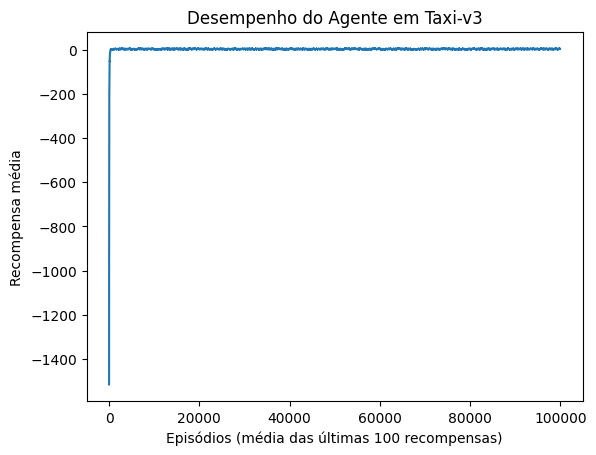

In [9]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt

# Cria o ambiente
streets = gym.make("Taxi-v3").env

# Inicializa a Q-table com zeros
q_table = np.zeros([streets.observation_space.n, streets.action_space.n])

# Configurações de aprendizado
learning_rate = 0.5  # Aumentada para permitir aprendizado mais rápido
discount_factor = 0.99  # Aumentado para priorizar recompensas futuras
initial_exploration = 1.0  # Taxa de exploração inicial
final_exploration = 0.1  # Taxa de exploração final
decay_rate = 0.995  # Taxa de decaimento da exploração
epochs = 100000  # Número de episódios

# Lista para armazenar as recompensas
reward_list = []

# Loop principal de treinamento
for taxi_run in range(epochs):
    state = streets.reset()  # Reinicia o ambiente e obtém o estado inicial
    done = False  # Sinaliza se o episódio terminou
    total_reward = 0  # Recompensa total para o episódio

    while not done:  # Enquanto o episódio não terminar
        random_value = random.uniform(0, 1)  # Gera um valor aleatório entre 0 e 1
        if (random_value < initial_exploration):
            action = streets.action_space.sample()  # Explora uma ação aleatória
        else:
            action = np.argmax(q_table[state])  # Usa a ação com o maior valor Q

        next_state, reward, done, info = streets.step(action)  # Executa a ação e obtém o novo estado

        # Atualiza a Q-value usando a fórmula do Q-learning
        prev_q = q_table[state, action]  # Valor Q anterior
        next_max_q = np.max(q_table[next_state])  # Valor Q máximo do próximo estado
        new_q = (1 - learning_rate) * prev_q + learning_rate * (reward + discount_factor * next_max_q)  # Nova Q-value
        q_table[state, action] = new_q  # Atualiza a Q-table

        total_reward += reward  # Acumula a recompensa total
        state = next_state  # Move para o próximo estado
    
    # Armazena a recompensa total do episódio
    reward_list.append(total_reward)

    # Reduz a taxa de exploração
    initial_exploration = max(final_exploration, initial_exploration * decay_rate)

# Exibe a média das recompensas ao longo dos episódios
print(f"Média das recompensas após {epochs} episódios: {np.mean(reward_list)}")

# Plote a média das recompensas ao longo do tempo
plt.plot(np.convolve(reward_list, np.ones(100)/100, mode='valid'))
plt.xlabel('Episódios (média das últimas 100 recompensas)')
plt.ylabel('Recompensa média')
plt.title('Desempenho do Agente em Taxi-v3')
plt.show()


Média das recompensas após 50000 episódios: 1.38158


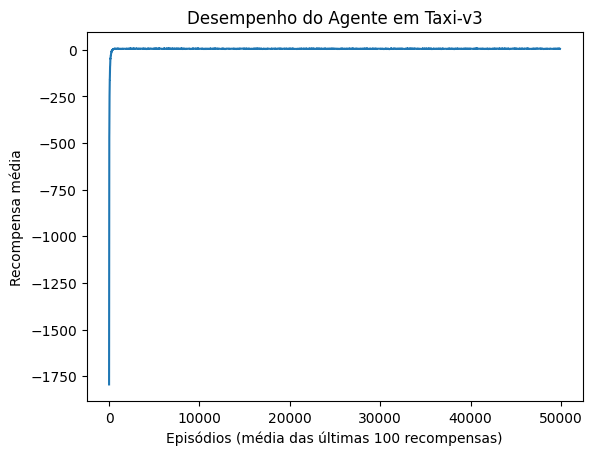

In [10]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt

# Cria o ambiente
streets = gym.make("Taxi-v3").env

# Inicializa a Q-table com zeros
q_table = np.zeros([streets.observation_space.n, streets.action_space.n])

# Configurações de aprendizado
learning_rate = 0.4  # Ajustado para ver se acelera o aprendizado
discount_factor = 0.95  # Mantido alto para priorizar recompensas futuras
initial_exploration = 1.0  # Taxa de exploração inicial
final_exploration = 0.05  # Taxa de exploração final
decay_rate = 0.995  # Taxa de decaimento da exploração
epochs = 50000  # Aumentado para dar mais tempo de aprendizado

# Lista para armazenar as recompensas
reward_list = []

# Loop principal de treinamento
for taxi_run in range(epochs):
    state = streets.reset()  # Reinicia o ambiente e obtém o estado inicial
    done = False  # Sinaliza se o episódio terminou
    total_reward = 0  # Recompensa total para o episódio

    while not done:  # Enquanto o episódio não terminar
        random_value = random.uniform(0, 1)  # Gera um valor aleatório entre 0 e 1
        if (random_value < initial_exploration):
            action = streets.action_space.sample()  # Explora uma ação aleatória
        else:
            action = np.argmax(q_table[state])  # Usa a ação com o maior valor Q

        next_state, reward, done, info = streets.step(action)  # Executa a ação e obtém o novo estado

        # Atualiza a Q-value usando a fórmula do Q-learning
        prev_q = q_table[state, action]  # Valor Q anterior
        next_max_q = np.max(q_table[next_state])  # Valor Q máximo do próximo estado
        new_q = (1 - learning_rate) * prev_q + learning_rate * (reward + discount_factor * next_max_q)  # Nova Q-value
        q_table[state, action] = new_q  # Atualiza a Q-table

        total_reward += reward  # Acumula a recompensa total
        state = next_state  # Move para o próximo estado
    
    # Armazena a recompensa total do episódio
    reward_list.append(total_reward)

    # Reduz a taxa de exploração
    initial_exploration = max(final_exploration, initial_exploration * decay_rate)

# Exibe a média das recompensas ao longo dos episódios
print(f"Média das recompensas após {epochs} episódios: {np.mean(reward_list)}")

# Plote a média das recompensas ao longo do tempo
plt.plot(np.convolve(reward_list, np.ones(100)/100, mode='valid'))
plt.xlabel('Episódios (média das últimas 100 recompensas)')
plt.ylabel('Recompensa média')
plt.title('Desempenho do Agente em Taxi-v3')
plt.show()


Média das recompensas após 500000 episódios: 4.942492


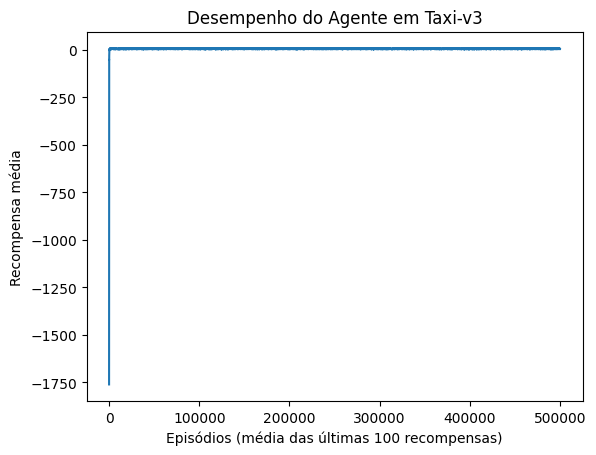

In [11]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt

# Cria o ambiente
streets = gym.make("Taxi-v3").env

# Inicializa a Q-table com zeros
q_table = np.zeros([streets.observation_space.n, streets.action_space.n])

# Configurações de aprendizado
learning_rate = 0.4  # Ajustado para ver se acelera o aprendizado
discount_factor = 0.95  # Mantido alto para priorizar recompensas futuras
initial_exploration = 1.0  # Taxa de exploração inicial
final_exploration = 0.05  # Taxa de exploração final
decay_rate = 0.995  # Taxa de decaimento da exploração
epochs = 500000  # Aumentado para dar mais tempo de aprendizado

# Lista para armazenar as recompensas
reward_list = []

# Loop principal de treinamento
for taxi_run in range(epochs):
    state = streets.reset()  # Reinicia o ambiente e obtém o estado inicial
    done = False  # Sinaliza se o episódio terminou
    total_reward = 0  # Recompensa total para o episódio

    while not done:  # Enquanto o episódio não terminar
        random_value = random.uniform(0, 1)  # Gera um valor aleatório entre 0 e 1
        if (random_value < initial_exploration):
            action = streets.action_space.sample()  # Explora uma ação aleatória
        else:
            action = np.argmax(q_table[state])  # Usa a ação com o maior valor Q

        next_state, reward, done, info = streets.step(action)  # Executa a ação e obtém o novo estado

        # Atualiza a Q-value usando a fórmula do Q-learning
        prev_q = q_table[state, action]  # Valor Q anterior
        next_max_q = np.max(q_table[next_state])  # Valor Q máximo do próximo estado
        new_q = (1 - learning_rate) * prev_q + learning_rate * (reward + discount_factor * next_max_q)  # Nova Q-value
        q_table[state, action] = new_q  # Atualiza a Q-table

        total_reward += reward  # Acumula a recompensa total
        state = next_state  # Move para o próximo estado
    
    # Armazena a recompensa total do episódio
    reward_list.append(total_reward)

    # Reduz a taxa de exploração
    initial_exploration = max(final_exploration, initial_exploration * decay_rate)

# Exibe a média das recompensas ao longo dos episódios
print(f"Média das recompensas após {epochs} episódios: {np.mean(reward_list)}")

# Plote a média das recompensas ao longo do tempo
plt.plot(np.convolve(reward_list, np.ones(100)/100, mode='valid'))
plt.xlabel('Episódios (média das últimas 100 recompensas)')
plt.ylabel('Recompensa média')
plt.title('Desempenho do Agente em Taxi-v3')
plt.show()


Média das recompensas após 500000 episódios: 4.695366


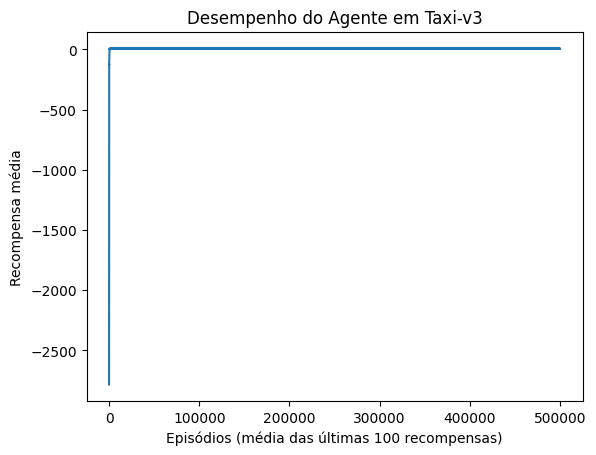

In [12]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt

# Cria o ambiente
streets = gym.make("Taxi-v3").env

# Inicializa duas Q-tables com zeros
q_table_a = np.zeros([streets.observation_space.n, streets.action_space.n])
q_table_b = np.zeros([streets.observation_space.n, streets.action_space.n])

# Configurações de aprendizado
learning_rate = 0.4  # Taxa de aprendizado
discount_factor = 0.95  # Fator de desconto
initial_exploration = 1.0  # Taxa de exploração inicial
final_exploration = 0.05  # Taxa de exploração final
decay_rate = 0.995  # Taxa de decaimento da exploração
epochs = 500000  # Número de episódios

# Lista para armazenar as recompensas
reward_list = []

# Loop principal de treinamento
for taxi_run in range(epochs):
    state = streets.reset()  # Reinicia o ambiente e obtém o estado inicial
    done = False  # Sinaliza se o episódio terminou
    total_reward = 0  # Recompensa total para o episódio

    while not done:  # Enquanto o episódio não terminar
        # Escolha aleatória entre as duas Q-tables
        if random.uniform(0, 1) < initial_exploration:
            action = streets.action_space.sample()  # Explora uma ação aleatória
        else:
            action = np.argmax(q_table_a[state]) if random.random() < 0.5 else np.argmax(q_table_b[state])

        next_state, reward, done, info = streets.step(action)  # Executa a ação e obtém o novo estado

        # Atualiza a tabela escolhida com a nova Q-value
        if random.random() < 0.5:
            prev_q = q_table_a[state, action]  # Valor Q anterior
            next_max_q = np.max(q_table_b[next_state])  # Valor Q máximo do próximo estado na tabela B
            new_q = (1 - learning_rate) * prev_q + learning_rate * (reward + discount_factor * next_max_q)  # Nova Q-value
            q_table_a[state, action] = new_q  # Atualiza a Q-table A
        else:
            prev_q = q_table_b[state, action]  # Valor Q anterior
            next_max_q = np.max(q_table_a[next_state])  # Valor Q máximo do próximo estado na tabela A
            new_q = (1 - learning_rate) * prev_q + learning_rate * (reward + discount_factor * next_max_q)  # Nova Q-value
            q_table_b[state, action] = new_q  # Atualiza a Q-table B

        total_reward += reward  # Acumula a recompensa total
        state = next_state  # Move para o próximo estado
    
    # Armazena a recompensa total do episódio
    reward_list.append(total_reward)

    # Reduz a taxa de exploração
    initial_exploration = max(final_exploration, initial_exploration * decay_rate)

# Exibe a média das recompensas ao longo dos episódios
print(f"Média das recompensas após {epochs} episódios: {np.mean(reward_list)}")

# Plote a média das recompensas ao longo do tempo
plt.plot(np.convolve(reward_list, np.ones(100)/100, mode='valid'))
plt.xlabel('Episódios (média das últimas 100 recompensas)')
plt.ylabel('Recompensa média')
plt.title('Desempenho do Agente em Taxi-v3')
plt.show()


## Seu desafio

Modifique o bloco acima para acompanhar os intervalos de tempo totais e use isso como uma métrica para avaliar a qualidade do nosso sistema Q-learning. Você pode querer aumentar o número de viagens simuladas e remover as chamadas sleep() para permitir a execução de mais amostras.

Agora, tente fazer experiências com os hiperparâmetros. Quão baixo pode chegar o número de épocas antes que nosso modelo comece a sofrer? Você consegue encontrar melhores taxas de aprendizagem, fatores de desconto ou fatores de exploração para tornar o treinamento mais eficiente? A taxa de exploração versus exploração, em particular, é interessante de experimentar.

In [13]:
import gym  # Importa a biblioteca gym para ambientes de aprendizado por reforço
import random  # Importa a biblioteca random para geração de números aleatórios
import numpy as np  # Importa a biblioteca numpy para operações numéricas
import time  # Importa a biblioteca time para medir intervalos de tempo

# Define a semente para a geração de números aleatórios, garantindo reprodutibilidade
random.seed(1234)

# Cria o ambiente "Taxi-v3"
streets = gym.make("Taxi-v3").env

# Renderiza o ambiente, exibindo a interface gráfica
streets.render()


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



Média das recompensas após 500000 episódios: 19.881794
Tempo médio das viagens: 0.00018508037757873535 segundos


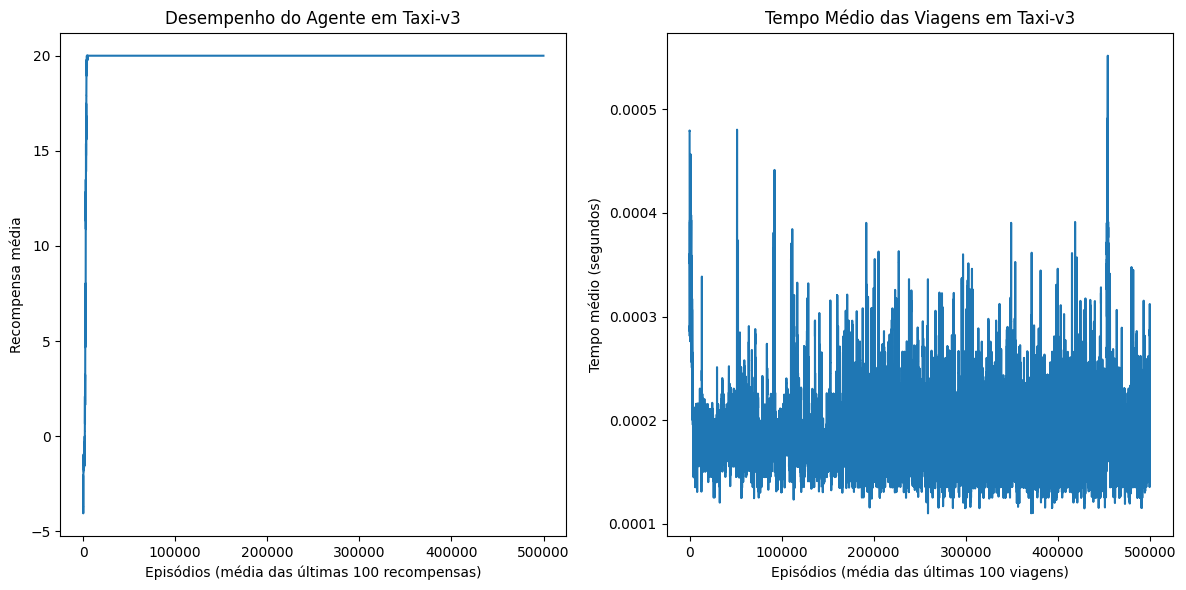

In [14]:
q_table_a = np.zeros([streets.observation_space.n, streets.action_space.n])
q_table_b = np.zeros([streets.observation_space.n, streets.action_space.n])

# Configurações de aprendizado
learning_rate = 0.4  # Taxa de aprendizado
discount_factor = 0.95  # Fator de desconto
initial_exploration = 1.0  # Taxa de exploração inicial
final_exploration = 0.05  # Taxa de exploração final
decay_rate = 0.995  # Taxa de decaimento da exploração
epochs = 500000  # Número de episódios

# Lista para armazenar as recompensas e tempos de viagem
reward_list = []
time_list = []

# Loop principal de treinamento
for taxi_run in range(epochs):
    state = streets.reset()  # Reinicia o ambiente e obtém o estado inicial
    
    done = False  # Sinaliza se a viagem terminou
    trip_length = 0  # Contador para o comprimento da viagem
    start_time = time.time()  # Marca o tempo inicial da viagem
    
    while not done and trip_length < 25:  # Limita a 25 passos
        action = np.argmax(q_table_a[state]) if random.random() < 0.5 else np.argmax(q_table_b[state])  # Escolhe a ação
        next_state, reward, done, info = streets.step(action)  # Executa a ação
        
        # Atualiza a tabela escolhida com a nova Q-value
        if random.random() < 0.5:
            prev_q = q_table_a[state, action]
            next_max_q = np.max(q_table_b[next_state])
            new_q = (1 - learning_rate) * prev_q + learning_rate * (reward + discount_factor * next_max_q)
            q_table_a[state, action] = new_q
        else:
            prev_q = q_table_b[state, action]
            next_max_q = np.max(q_table_a[next_state])
            new_q = (1 - learning_rate) * prev_q + learning_rate * (reward + discount_factor * next_max_q)
            q_table_b[state, action] = new_q

        state = next_state  # Atualiza o estado atual
        trip_length += 1  # Incrementa o contador do comprimento da viagem
    
    total_time = time.time() - start_time  # Calcula o tempo total da viagem
    reward_list.append(reward)  # Armazena a recompensa do episódio
    time_list.append(total_time)  # Armazena o tempo da viagem

    # Reduz a taxa de exploração
    initial_exploration = max(final_exploration, initial_exploration * decay_rate)

# Exibe a média das recompensas e o tempo médio das viagens
print(f"Média das recompensas após {epochs} episódios: {np.mean(reward_list)}")
print(f"Tempo médio das viagens: {np.mean(time_list)} segundos")

# Plote as recompensas e tempos ao longo do tempo
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(np.convolve(reward_list, np.ones(100)/100, mode='valid'))
plt.xlabel('Episódios (média das últimas 100 recompensas)')
plt.ylabel('Recompensa média')
plt.title('Desempenho do Agente em Taxi-v3')

plt.subplot(1, 2, 2)
plt.plot(np.convolve(time_list, np.ones(100)/100, mode='valid'))
plt.xlabel('Episódios (média das últimas 100 viagens)')
plt.ylabel('Tempo médio (segundos)')
plt.title('Tempo Médio das Viagens em Taxi-v3')

plt.tight_layout()
plt.show()

Média das recompensas após 500000 episódios: 19.803752
Tempo médio das viagens: 0.0001599047532081604 segundos


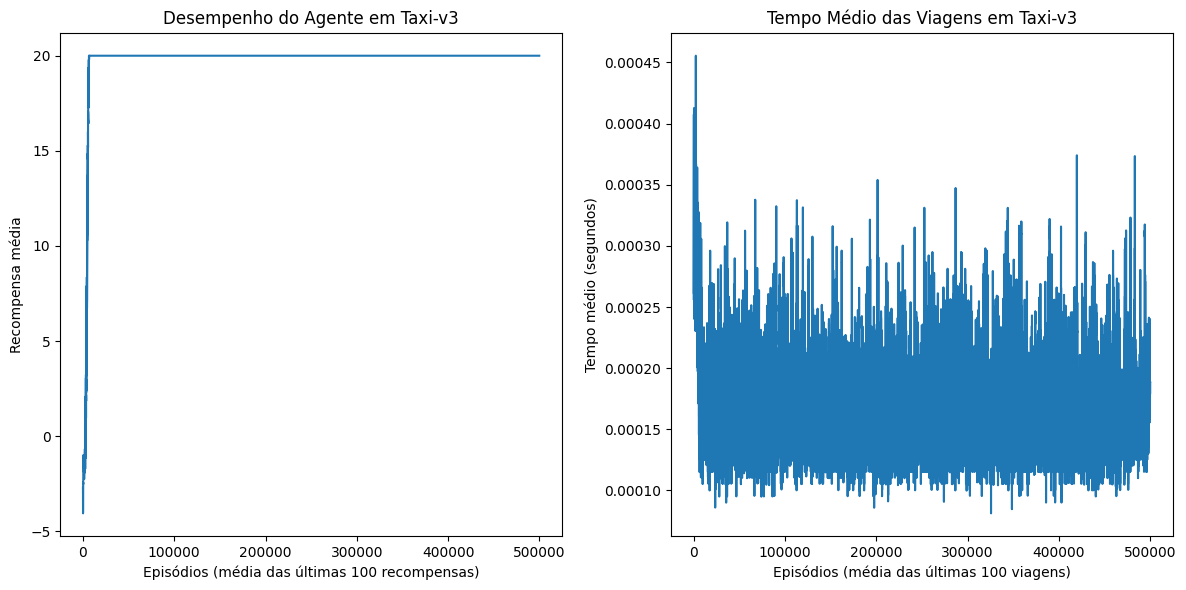

In [15]:
import gym
import random
import numpy as np
import time
import matplotlib.pyplot as plt

# Configurações iniciais
random.seed(1234)
streets = gym.make("Taxi-v3").env

# Inicializa as Q-tables
q_table_a = np.zeros([streets.observation_space.n, streets.action_space.n])
q_table_b = np.zeros([streets.observation_space.n, streets.action_space.n])

# Hiperparâmetros
learning_rate = 0.2  # Taxa de aprendizado ajustada
discount_factor = 0.99  # Fator de desconto ajustado
initial_exploration = 1.0
final_exploration = 0.05
decay_rate = 0.995
epochs = 500000

# Armazenamento de recompensas e tempos
reward_list = []
time_list = []

for taxi_run in range(epochs):
    state = streets.reset()
    done = False
    trip_length = 0
    start_time = time.time()

    while not done and trip_length < 25:
        action = np.argmax(q_table_a[state]) if random.random() < 0.5 else np.argmax(q_table_b[state])
        next_state, reward, done, info = streets.step(action)

        # Atualiza as Q-tables
        if random.random() < 0.5:
            prev_q = q_table_a[state, action]
            next_max_q = np.max(q_table_b[next_state])
            new_q = (1 - learning_rate) * prev_q + learning_rate * (reward + discount_factor * next_max_q)
            q_table_a[state, action] = new_q
        else:
            prev_q = q_table_b[state, action]
            next_max_q = np.max(q_table_a[next_state])
            new_q = (1 - learning_rate) * prev_q + learning_rate * (reward + discount_factor * next_max_q)
            q_table_b[state, action] = new_q

        state = next_state
        trip_length += 1

    total_time = time.time() - start_time
    reward_list.append(reward)
    time_list.append(total_time)

    initial_exploration = max(final_exploration, initial_exploration * decay_rate)

# Resultados
print(f"Média das recompensas após {epochs} episódios: {np.mean(reward_list)}")
print(f"Tempo médio das viagens: {np.mean(time_list)} segundos")

# Gráficos
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(np.convolve(reward_list, np.ones(100)/100, mode='valid'))
plt.xlabel('Episódios (média das últimas 100 recompensas)')
plt.ylabel('Recompensa média')
plt.title('Desempenho do Agente em Taxi-v3')

plt.subplot(1, 2, 2)
plt.plot(np.convolve(time_list, np.ones(100)/100, mode='valid'))
plt.xlabel('Episódios (média das últimas 100 viagens)')
plt.ylabel('Tempo médio (segundos)')
plt.title('Tempo Médio das Viagens em Taxi-v3')

plt.tight_layout()
plt.show()


Média das recompensas após 500000 episódios: 20.0


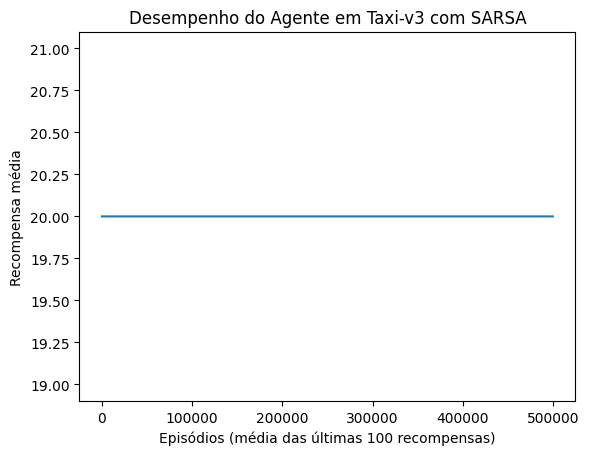

In [16]:
# SARSA
import gym
import random
import numpy as np
import time
import matplotlib.pyplot as plt

# Cria o ambiente "Taxi-v3"
streets = gym.make("Taxi-v3").env

# Inicializa a Q-table
q_table = np.zeros([streets.observation_space.n, streets.action_space.n])

# Hiperparâmetros
learning_rate = 0.2
discount_factor = 0.99
initial_exploration = 1.0
final_exploration = 0.05
decay_rate = 0.995
epochs = 500000

reward_list = []

for taxi_run in range(epochs):
    state = streets.reset()
    action = streets.action_space.sample()  # Ação inicial aleatória
    done = False

    while not done:
        next_state, reward, done, info = streets.step(action)

        # Atualiza a Q-value usando a regra SARSA
        next_action = streets.action_space.sample() if random.uniform(0, 1) < initial_exploration else np.argmax(q_table[next_state])
        q_table[state, action] += learning_rate * (reward + discount_factor * q_table[next_state, next_action] - q_table[state, action])

        state = next_state
        action = next_action

    reward_list.append(reward)
    initial_exploration = max(final_exploration, initial_exploration * decay_rate)

print(f"Média das recompensas após {epochs} episódios: {np.mean(reward_list)}")

# Gráficos
plt.plot(np.convolve(reward_list, np.ones(100)/100, mode='valid'))
plt.xlabel('Episódios (média das últimas 100 recompensas)')
plt.ylabel('Recompensa média')
plt.title('Desempenho do Agente em Taxi-v3 com SARSA')
plt.show()
